In [1]:
%matplotlib inline
#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
import math, sys, os
from numpy.random import randn
from sklearn.datasets import make_blobs

# setup pyspark for IPython_notebooks
spark_home = os.environ.get('SPARK_HOME', None)
sys.path.insert(0, spark_home + "/python")
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home, 'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/

Using Python version 2.7.10 (default, Jul 13 2015 12:05:58)
SparkContext available as sc, HiveContext available as sqlContext.


In [28]:
data_home = os.environ.get('DATA_HOME', None)
sys.path.insert(0, data_home)

# data
from gen_data import make_blobs_rdd

# utilitiy functions for this notebook
from lsh_util import *

# make some data
N = 1000
d = 2
k = 3
sigma = 3.0
bound = 10

data_RDD = make_blobs_rdd(N, d, k, sigma, bound, sc)
data_RDD.take(2)

[(2, array([ 1.29677425, -0.65074479])),
 (1, array([-1.63247354,  0.42624974]))]

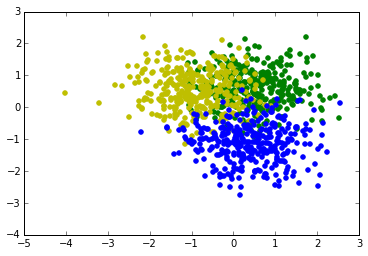

In [29]:
c0 = np.stack(data_RDD.filter(lambda t: t[0] == 0).map(lambda t: t[1]).collect())
c1 = np.stack(data_RDD.filter(lambda t: t[0] == 1).map(lambda t: t[1]).collect())
c2 = np.stack(data_RDD.filter(lambda t: t[0] == 2).map(lambda t: t[1]).collect())

plt.scatter(c0[:,0],c0[:,1],color='g')
plt.scatter(c1[:,0],c1[:,1],color='y')
plt.scatter(c2[:,0],c2[:,1],color='b')

# Hierarchical kMeans Hashing

In [30]:
from scipy.spatial.distance import euclidean

def config_kmeans_hashing(ranges, mins, k = 5, l = 5, seed = None):  
    """
    ranges: array of data range for each dimension
    mins: array of minimum values along each dimension
    k: number of centroids per hash table
    l: number of hash tables
    """
    # generate k x l centers, sampled from a uniform random over the range of the seen data
    #   i.e. for each dim ~ Unif([d_min,d_max])
    d = len(ranges)
    centers = (np.random.rand(l, k, d) * np.tile(ranges,(l, k, 1))) + np.tile(mins,(l, k, 1))
    
    def hash_func(tup):
        y, x = tup # expect key (int, 1xD vector)
        # O(l x k)
        buckets = [np.argmin([euclidean(x, centers[j,c,:]) for c in range(k)]) for j in range(l)]
        out = {  "hash_buckets": buckets,
                 "original_cluster": y,
                 "vector": x }
        return out
    
    return hash_func

In [35]:
ranges, mins = get_ranges(data_RDD)
k = 20
l = 20

hashing_func = config_kmeans_hashing(ranges, mins, k, l)
hashed = data_RDD.map(hashing_func)

# hashed.takeSample(False,10)

# Find the neighbors of a point

In [36]:
point = data_RDD.takeSample(False,1)[0]
hashed_point = hashing_func(point)
print "Our point: "
print hashed_point

Our point: 
{'hash_buckets': [7, 8, 11, 18, 0, 2, 1, 14, 14, 0, 7, 16, 19, 5, 19, 18, 19, 19, 2, 15], 'vector': array([ 0.19681764,  0.54543698]), 'original_cluster': 2}


In [43]:
neighbors_dics = {}

show = 10
for h in range(k):
    idx = h+1
    neigh = data_RDD.map(hashing_func).filter(lambda hp: hp["hash_buckets"][:idx] == hashed_point["hash_buckets"][:idx])
    neighbors_dics[h] = np.stack(neigh.map(lambda d: d["vector"]).collect())
    if h < show + 1:
        print "Found %d neighbors with the first %d hash functions" % (neighbors_dics[h].shape[0], idx)

Found 268 neighbors with the first 1 hash functions
Found 120 neighbors with the first 2 hash functions
Found 70 neighbors with the first 3 hash functions
Found 12 neighbors with the first 4 hash functions
Found 12 neighbors with the first 5 hash functions
Found 6 neighbors with the first 6 hash functions
Found 6 neighbors with the first 7 hash functions
Found 6 neighbors with the first 8 hash functions
Found 5 neighbors with the first 9 hash functions
Found 5 neighbors with the first 10 hash functions
Found 5 neighbors with the first 11 hash functions


# Visualizing the found neighbors

In [44]:
data = np.stack(data_RDD.map(lambda t: t[1]).collect())
point_array = point[1]

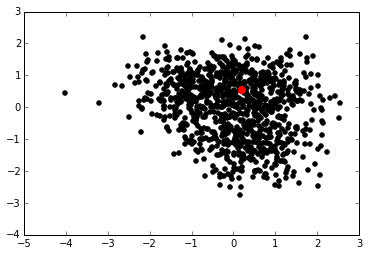

In [45]:
plt.scatter(data[:,0], data[:,1], color='k')
plt.scatter(point_array[0],point_array[1], color='r', s = 50)

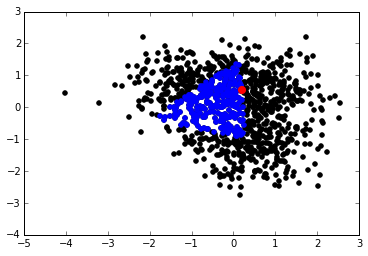

In [49]:
hash_funcs = 0
n_data = neighbors_dics[hash_funcs]
plt.scatter(data[:,0], data[:,1], color='k')
plt.scatter(n_data[:,0], n_data[:,1], color='b')
plt.scatter(point_array[0],point_array[1], color='r', s = 50)

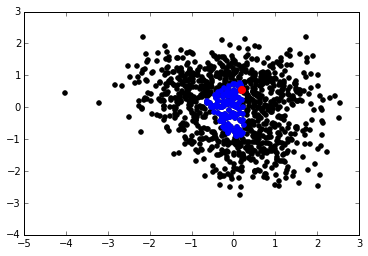

In [50]:
hash_funcs = 1
n_data = neighbors_dics[hash_funcs]
plt.scatter(data[:,0], data[:,1], color='k')
plt.scatter(n_data[:,0], n_data[:,1], color='b')
plt.scatter(point_array[0],point_array[1], color='r', s = 50)

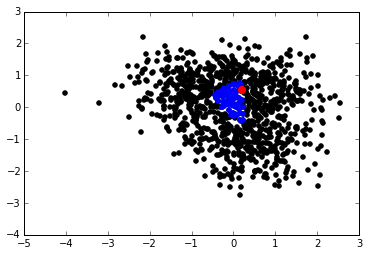

In [51]:
hash_funcs = 2
n_data = neighbors_dics[hash_funcs]
plt.scatter(data[:,0], data[:,1], color='k')
plt.scatter(n_data[:,0], n_data[:,1], color='b')
plt.scatter(point_array[0],point_array[1], color='r', s = 50)

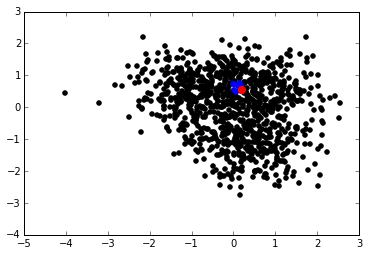

In [52]:
hash_funcs = 3
n_data = neighbors_dics[hash_funcs]
plt.scatter(data[:,0], data[:,1], color='k')
plt.scatter(n_data[:,0], n_data[:,1], color='b')
plt.scatter(point_array[0],point_array[1], color='r', s = 50)

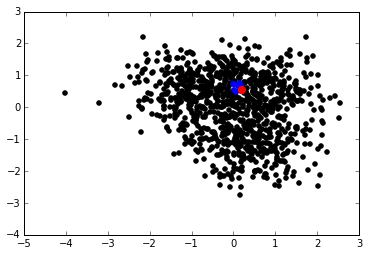

In [53]:
hash_funcs = 4
n_data = neighbors_dics[hash_funcs]
plt.scatter(data[:,0], data[:,1], color='k')
plt.scatter(n_data[:,0], n_data[:,1], color='b')
plt.scatter(point_array[0],point_array[1], color='r', s = 50)